In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
customer_df = pd.read_csv('we_fn_use_c_marketing_customer_value_analysis.csv')
# display(customer_df.shape)
# customer_df.head()

In [3]:
cols = []
for column in customer_df.columns:
    cols.append(column.lower())
customer_df.columns = cols

In [4]:
customer_df.columns= customer_df.columns. str. replace(' ','_')

In [5]:
customer_df['effective_to_date']= pd.to_datetime(customer_df['effective_to_date'])

In [6]:
# customer_df.info()

In [8]:
# customer_df['number_of_open_complaints'].value_counts()  # should be categorical as it is devided to categories

In [9]:
customer_df['number_of_open_complaints']= customer_df['number_of_open_complaints'].astype(str)

In [10]:
#Check all unique values of columns
# customer_df.nunique()

In [11]:
numeric = customer_df.select_dtypes(include = np.number)
# numeric

In [12]:
def cont_discr(df):
    discrete = []
    continuous = []
    for col in df:
        if df[col].nunique() <= 36:
            discrete.append(col)
        else:
            continuous.append(col)
    return discrete,continuous

In [13]:
cont_discr(numeric)

(['months_since_last_claim', 'number_of_policies'],
 ['customer_lifetime_value',
  'income',
  'monthly_premium_auto',
  'months_since_policy_inception',
  'total_claim_amount'])

In [11]:
discrete_num = customer_df[['months_since_last_claim', 'number_of_policies']]
continuous_num = customer_df[['customer_lifetime_value',
  'income',
  'monthly_premium_auto',
  'months_since_policy_inception',
  'total_claim_amount']]

In [ ]:
customer_df.isnull().sum()

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(numeric.corr(), annot=True)

### there is a pretty high correlation between 'total claim amount' and 'monthly premium auto'
### the second highest correlation is between 'monthly premium auto' and 'customer lifetime value'

In [12]:
customer_df['income'].value_counts()  # a lot of 0.. i will try to predict what is the missing income value based on the other variables

0        2317
95697      12
27972       7
25370       7
61108       7
         ... 
36529       1
25859       1
38179       1
70190       1
21941       1
Name: income, Length: 5694, dtype: int64

<AxesSubplot:>

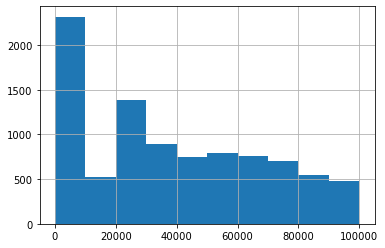

In [13]:
customer_df['income'].hist()

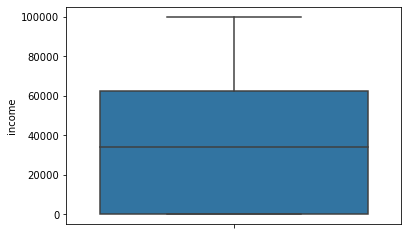

In [14]:
sns.boxplot(y=customer_df['income'])
plt.show()   #no outliers

In [15]:
numericals_with_income = numeric.loc[numeric['income'] > 0]
numericals_with_income

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_policies,total_claim_amount
0,2763.519279,56274,69,32,5,1,384.811147
2,12887.431650,48767,108,18,38,2,566.472247
4,2813.692575,43836,73,12,44,1,138.130879
5,8256.297800,62902,69,14,94,2,159.383042
6,5380.898636,55350,67,0,13,9,321.600000
...,...,...,...,...,...,...,...
9127,5032.165498,66367,64,6,48,3,307.200000
9128,4100.398533,47761,104,16,58,1,541.282007
9129,23405.987980,71941,73,18,89,2,198.234764
9130,3096.511217,21604,79,14,28,1,379.200000


In [16]:
X_income = numericals_with_income.drop(['income','months_since_policy_inception'],axis=1)
y_income = numericals_with_income['income']

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
X_normalized_income = pd.DataFrame(MinMaxScaler().fit_transform(X_income), columns=X_income.columns)

In [18]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(X_normalized_income,y_income)
KNN.score(X_normalized_income,y_income)   # in 43% of the predictions we will be right - is it enough to continue?

0.4339152119700748

In [19]:
X_all = numeric.drop(['income','months_since_policy_inception'],axis=1)
X_normalized_all = pd.DataFrame(MinMaxScaler().fit_transform(X_all), columns=X_all.columns)
y_all = numeric['income']

In [20]:
predicted_income = pd.Series(KNN.predict(X_normalized_all),name='predicted_income') 

In [21]:
predicted_income.value_counts(dropna=False)  

95697    16
17950    15
19121    15
20978    15
12843    14
         ..
21724     1
61725     1
68507     1
64669     1
28360     1
Name: predicted_income, Length: 2867, dtype: int64

In [22]:
customer_df = pd.concat([customer_df,predicted_income],axis=1)

In [23]:
customer_df['final_income'] =  np.where(customer_df['income']== 0, customer_df['predicted_income'], customer_df['income'])

In [24]:
customer_df.head()

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,...,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,predicted_income,final_income
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,...,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,56274,56274
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,2011-01-31,Unemployed,F,0,...,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,13908,13908
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,...,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize,25074,48767
3,WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,...,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize,24982,24982
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,...,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize,33462,43836


<AxesSubplot:>

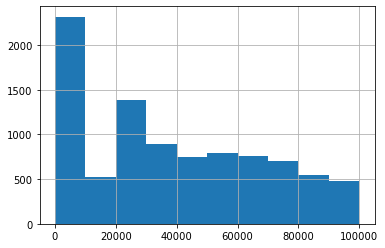

In [25]:
customer_df['income'].hist()

<AxesSubplot:>

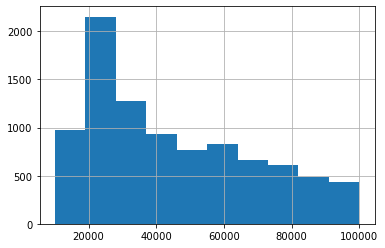

In [26]:
customer_df['final_income'].hist()

In [27]:
customer_df.drop(['income','predicted_income'],axis=1,inplace=True) #droping the columns we dont need of the income with missing values and not fully corecct income
customer_df.head()

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,location_code,...,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,final_income
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,Suburban,...,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,56274
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,2011-01-31,Unemployed,F,Suburban,...,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,13908
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,Suburban,...,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize,48767
3,WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,Suburban,...,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize,24982
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,Rural,...,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize,43836


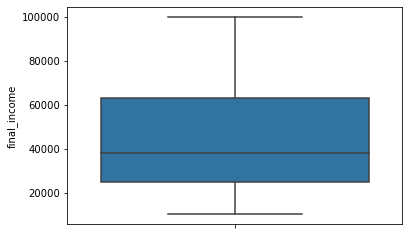

In [28]:
sns.boxplot(y=customer_df['final_income'])
plt.show()

In [29]:
# plot a boxplot to continuos and mention outlieres 

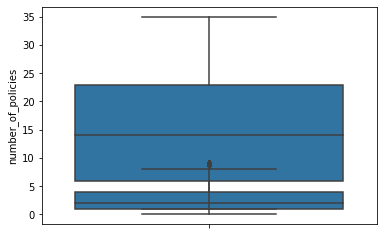

In [30]:
def plot_box(df):
    for column in df.columns:
        sns.boxplot(y=df[column])
        plt.show
    return None    
plot_box(discrete_num)

In [52]:
y = customer_df['total_claim_amount']
X = customer_df.drop('total_claim_amount', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

In [53]:
from sklearn.preprocessing import MinMaxScaler

X_train_num = X_train.select_dtypes(include = np.number)

# scaling data
transformer = MinMaxScaler().fit(X_train_num) 
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

In [54]:
X_train_norm.columns = X_train_num.columns
X_train_norm.head()

,customer_lifetime_value,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_policies,final_income
0,0.085854,0.215190,0.600000,0.656566,0.625,0.745653
1,0.070908,0.143460,0.314286,0.464646,0.250,0.584197
2,0.040031,0.016878,0.314286,0.969697,0.500,0.925754
3,0.079933,0.185654,0.942857,0.909091,0.375,0.634739
4,0.034779,0.265823,0.371429,0.313131,0.000,0.126167


In [31]:
categorical=customer_df.select_dtypes(include = object)

In [ ]:
# categorical
# looking at the categories, they all make sense as categorical data 
# i will drop 'customer' because it doesnt give any valuable information 
# i will drop 'policy' because it repets the information in 'policy_type' and doesnt give me valuable information

In [32]:
categorical = categorical.drop(['customer'], axis=1)      #drop customer

In [33]:
categorical = categorical.drop(['policy'], axis=1)    #drop policy

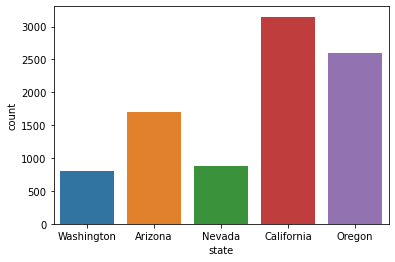

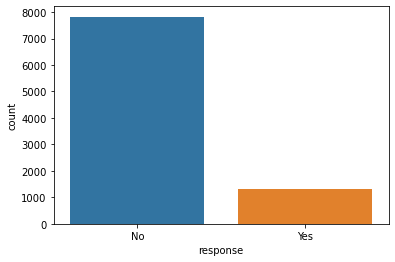

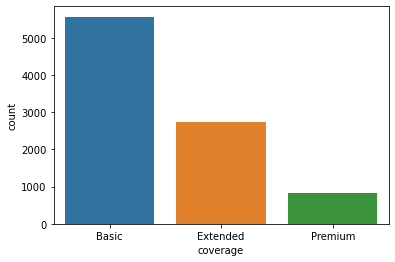

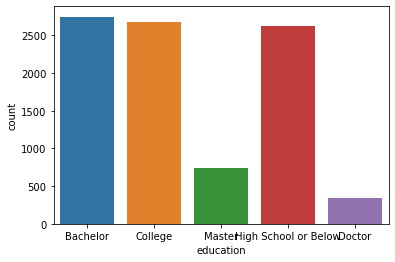

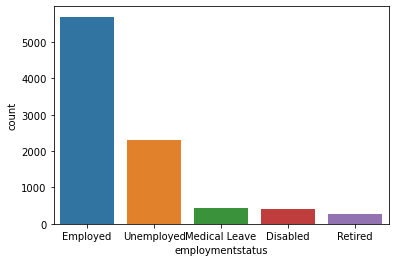

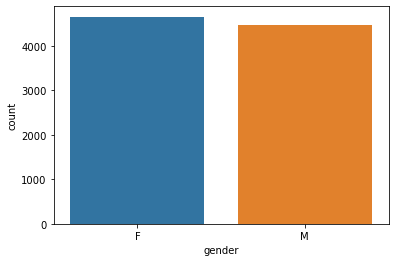

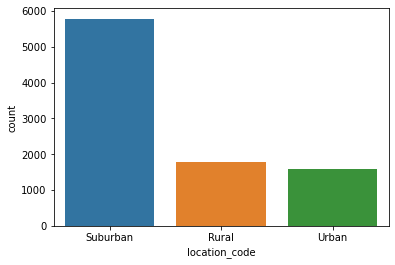

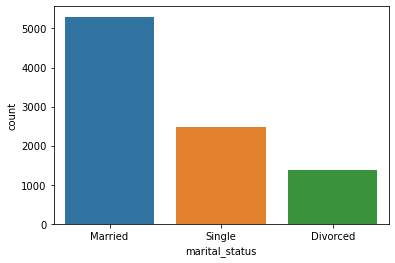

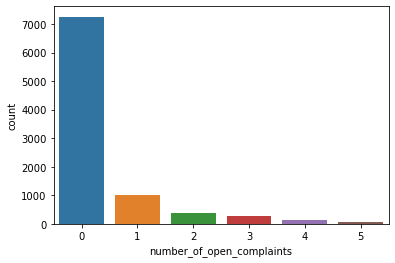

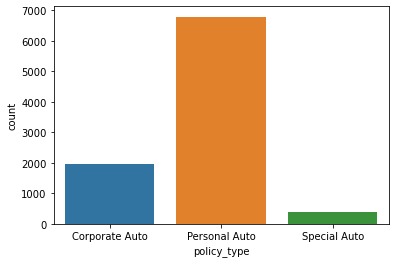

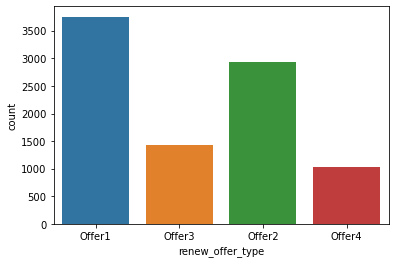

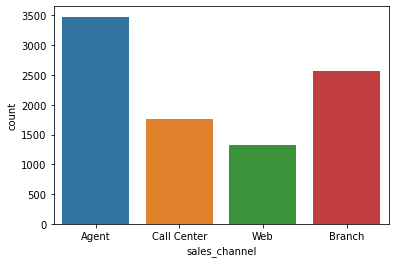

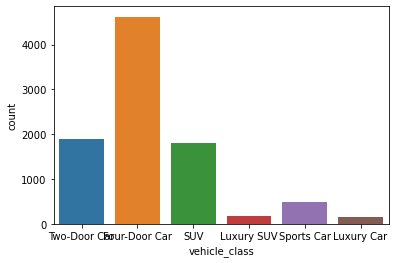

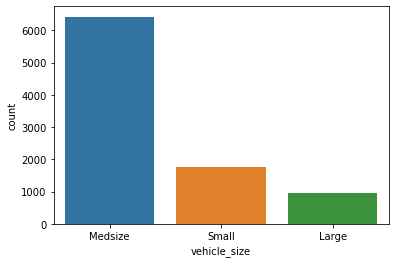

In [34]:
def count_plot(df):
    for column in df.columns:
        sns.countplot(x=df[column])
        plt.show()
    return None
count_plot(categorical)




## conclutions:
#### state - Onehot endoder   (DONE)
#### response - change 'yes' and 'no' to 1 and 0    (DONE)
#### coverage - ordinal encoder (basic-0, extended-1,premium-2) (DONE)
#### education - add 'master' and 'doctor' into one category called 'higher education' and then ordinal encod them as: 
####                          (high school or below - 0, college - 1, bachelor - 2, higher education - 3)   (DONE)
#### employmentstatus - Onehot endoder    (DONE)
#### gender - Onehot encoder    (DONE)
#### location_code - Onehot encoder   (DONE)
#### marital_status - Onehot encoder     (DONE)
#### number_of_open_complains - Onehot encoder    (DONE)
#### policy_type - Onehot encoder     (DONE)
#### renew_offer_type - Onehot encoder    (DONE)
#### sales_channel - Onehot encoder    (DONE)
#### vehicle_class - add luxury car and usv to one category called 'luxury car' and then ordinal encode them as:
####                           (four door car - 0, two door car - 1, suv - 2, luxury - 3)    (DONE)
#### vehicle_size - ordinal encode (small - 0, medsize - 1, large - 2)    (DONE)
#
#
#
#


 

In [ ]:
# saving my categoricals to csv file before encoding them

In [35]:
categorical_csv = categorical.to_csv('categorical.csv')

In [ ]:
# encoding categoricals

In [36]:
categorical['response'] = np.where(categorical['response']=='Yes',1,0)

In [37]:
categorical['response'].value_counts()

0    7826
1    1308
Name: response, dtype: int64

In [38]:
categoricals = categorical[['state','employmentstatus','gender','location_code','marital_status','policy_type','renew_offer_type','sales_channel']]

In [ ]:
categoricals

In [39]:
from sklearn.preprocessing import OneHotEncoder  #one hot encoding

encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(categoricals) 
categoricals_encoded = encoder.transform(categoricals).toarray()
categoricals_encoded = encoder.transform(categoricals).toarray()

In [40]:
encoder.categories_

[array(['Arizona', 'California', 'Nevada', 'Oregon', 'Washington'],
       dtype=object),
 array(['Disabled', 'Employed', 'Medical Leave', 'Retired', 'Unemployed'],
       dtype=object),
 array(['F', 'M'], dtype=object),
 array(['Rural', 'Suburban', 'Urban'], dtype=object),
 array(['Divorced', 'Married', 'Single'], dtype=object),
 array(['Corporate Auto', 'Personal Auto', 'Special Auto'], dtype=object),
 array(['Offer1', 'Offer2', 'Offer3', 'Offer4'], dtype=object),
 array(['Agent', 'Branch', 'Call Center', 'Web'], dtype=object)]

In [ ]:
# !pip install seaborn==0.9.0

In [42]:
categorical["coverage"] = categorical["coverage"].map({"Basic" : 0, "Extended" : 1, "Premium" : 2})

In [43]:
categorical['education']=np.where(categorical['education']=="Master","Higher education",categorical['education'])

In [44]:
categorical['education']=np.where(categorical['education']=="Doctor","Higher education",categorical['education'])

In [45]:
categorical["education"] = categorical["education"].map({"High School or Below" : 0, "College" : 1, "Bachelor" : 2, "Higher education" : 3})

In [46]:
categorical['vehicle_class'] = np.where(categorical['vehicle_class']=="Luxury Car", "Luxury", categorical['vehicle_class'])

In [47]:
categorical['vehicle_class'] = np.where(categorical['vehicle_class']=="Luxury SUV", "Luxury", categorical['vehicle_class'])

In [48]:
categorical['vehicle_class'] = categorical['vehicle_class'].map({"Four-Door Car" : 0, "Two-Door Car" : 1, "SUV" : 2, "Sports Car" : 3, "Luxury" : 4})

In [49]:
categorical["vehicle_size"] = categorical["vehicle_size"].map({"Small" : 0, "Medsize" : 1, "Large" : 2})

In [ ]:
sns.set(rc={'figure.figsize': (15,8)})
sns.lineplott(x="effective_to_date", y="total_claim_amount", data=customer_df)

In [14]:
# plt.plot(customer_df['total_claim_amount'],customer_df['effective_to_date']) 

In [ ]:
data_transformed = pd.concatenate([])

In [ ]:
# This is what I have at the moment .. I prefer to submit it this way and if I have time later, fix and submit it again